# Nuclei segmentation

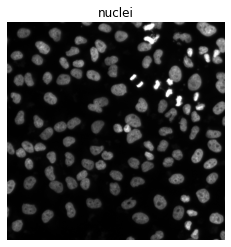

In [1]:
import tifffile
import matplotlib.pyplot as plt

# We start loading the image
img = tifffile.imread('../data/nuclei.tif')
img = img[0:511,0:511]

# Let's display the image that we just loaded
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('nuclei')
plt.show()

In [2]:
import numpy as np
from scipy import ndimage, misc

# Apply a median filter to the image
filtered = ndimage.median_filter(img, size=3)

Threshold the image

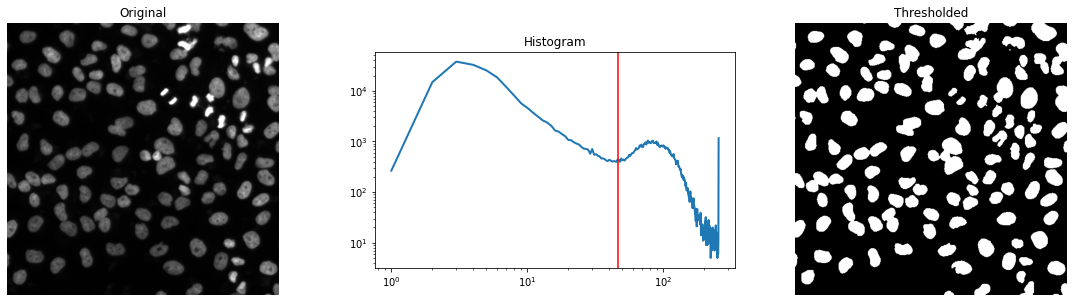

In [32]:
from skimage.filters import threshold_otsu
from skimage import morphology 
from scipy import ndimage
from skimage.exposure import histogram

def threshold_sigma(img, pfa):
    ''' compute a threshold based on the background of the image '''
    import scipy.stats
    img = np.sqrt(img)
    m0 = np.median(img)
    s0 = 1.48 * np.median(np.abs(img - m0))
    return pow(m0 + scipy.stats.norm.ppf(1-pfa) * s0, 2.0)

# Let's use the function we defined to estimate a threshold:
threshold = threshold_sigma(filtered, 0.001)

# Alternatively, we can use the Otsu threshold:
#threshold = threshold_otsu(filtered)

# Threshold the image
mask = filtered > threshold

# Fill holes in the mask
mask = ndimage.binary_fill_holes(mask).astype(int)

#mask = morphology.erosion(mask)

# Display the mask
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].imshow(filtered, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

hist, hist_centers = histogram(filtered)
ax[1].loglog(hist_centers, hist, lw=2)
ax[1].set_title('Histogram')
ax[1].axvline((threshold), color='r')
ax[1].set_position([0.4,0.2,0.25,0.6])

ax[2].imshow(mask, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')
fig.show()


Let's separate touching object using a watershed based approach

Elapsed time: 0.27 s


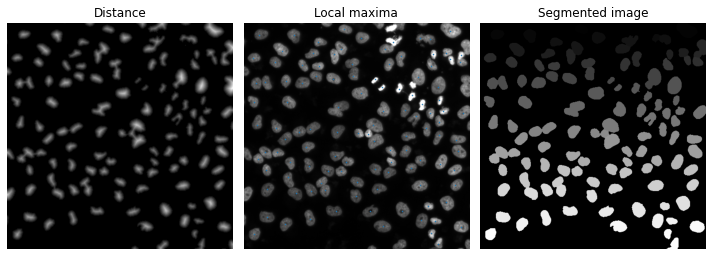

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import measure
from timeit import default_timer as timer

tic = timer()

# Compute the distance where mask is True to the closest point where it is False
distance = ndi.distance_transform_edt(mask)

# Extract local maxima from the distance
coords = peak_local_max(distance, min_distance=10)
peak = np.zeros(distance.shape, dtype=bool)
peak[tuple(coords.T)] = True
peak = np.logical_and(peak, mask)

# Define markers by finding connected component in the image
markers = measure.label(peak, background=0)

# Use the watershed with the distance function as priority map 
# and markers as seeds.
labels = watershed(-distance, markers, mask=mask)

# We can now display the 3 steps used to
fig, ax = plt.subplots(1, 3,figsize=(10,5))
ax[0].imshow(distance,cmap='gray')
ax[0].set_title('Distance')

ax[1].imshow(img,cmap='gray')
ax[1].plot(coords[:,1], coords[:,0], '.', markersize=1)
ax[1].set_title('Local maxima')

ax[2].imshow(labels,cmap='gray')
ax[2].set_title('Segmented image')
for a in ax:
    a.set_axis_off()
fig.tight_layout()

# Display elapsed time for this step
etime = timer() - tic
print(f"Elapsed time: {etime:.2f} s")


We can also compute the contours 

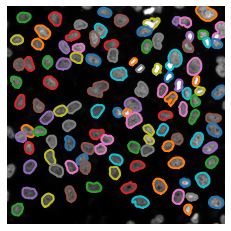

In [40]:
nlevels = np.max(labels)
contours = list()
for level in np.arange(1, nlevels) :
    c = measure.find_contours(labels == level)
    contours.append(c[0])

fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_axis_off()
plt.show()

Let's display now some information on the labelled regions. We can use a pandas frame to manipulate the result.

In [41]:
import pandas as pd

props = measure.regionprops_table(labels, img, properties=('area', 'mean_intensity','eccentricity','major_axis_length','perimeter'))
df = pd.DataFrame(props)

# Let's save thetable into a csv file
df.to_csv('results.csv') 

# We can inspect the first lines of the table
df.head()


,area,mean_intensity,eccentricity,major_axis_length
0,498,99.660643,0.776851,31.813456
1,1165,132.250644,0.788379,49.475098
2,545,73.425688,0.704807,31.351164
3,661,81.945537,0.546580,32.001879
4,237,88.202532,0.590722,19.554784


We can plot the features in a scatter plot and try to define a rule to classify the nuclei according to those features:

In [42]:
from matplotlib import cm

def show_classification(df,contours,img,f1,f2,C):
    cmap = cm.get_cmap('viridis',np.max(C)+1)
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].scatter(df[f1], df[f2], s=2, c=C,cmap=cmap)
    ax[0].set_xlabel(f1)
    ax[0].set_ylabel(f2)
    ax[0].set_position([0.1,0.3,0.4,0.4])
    ax[0].set_title('Nuclei features')
    ax[1].imshow(img, cmap=plt.cm.gray)
    colors = cmap.colors
    for k,contour in enumerate(contours):
        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1, color=colors[C[k]])
    ax[1].set_axis_off()
    fig.show()

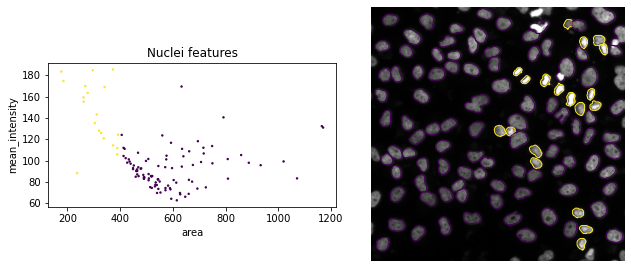

In [45]:
# Let's pick two features
f1 = 'area'
f2 = 'mean_intensity'

# We can define a rule as convert the logical value to an integer
C = np.array(df[f1] + 3*df[f2] > 700, dtype=int)
C = np.array(df[f1] < 400, dtype=int)

show_classification(df,contours,img,f1,f2,C)

We can try to group the features in clusters using scikit-learn. If not installed, type  ```conda install -c conda-forge scikit-learn``` in the miniconda console.

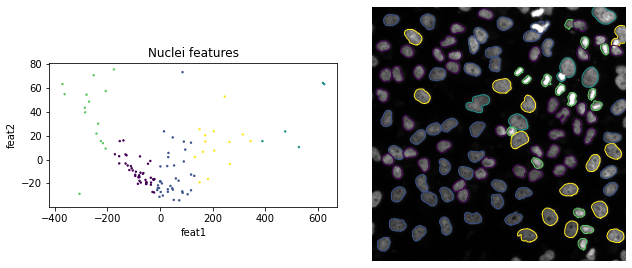

In [46]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Convert the features to a matrix

X = df.to_numpy()

# Reduce the dimensions of the dataset
pca = PCA(n_components=3)
Y = pca.fit_transform(X)
df2 = pd.DataFrame(data = Y, columns=['feat1','feat2','feat3'])

# Use a KMeans clustering to group nuclei according to their features
km = KMeans(n_clusters=5)
km.fit(Y)
C = km.labels_
show_classification(df2,contours,img,'feat1','feat2',C)

